In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
nwalk = 64
nsteps_d = 3000
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [13]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [14]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

In [15]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

In [16]:
# ph.fit_isochrone_lum() steps through all MESA isochrones and matches the ones that fit the given parameters
iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

# Write to csv, then read back in (keeps python notebook from crashing)
iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

100%|██████████| 738479/738479 [01:14<00:00, 9920.25it/s] 


In [17]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [18]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

In [19]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


In [20]:
pdist = np.random.normal(period, np.mean((abs(period_uerr), abs(period_lerr))), len(rho_star))

a_rs_gaia = ph.get_a_rs(rho_star, pdist)
a_rs_gaia_sigmin, a_rs_gaia_sigpls = ph.get_sigmas(a_rs_gaia)

a_rs_guess = np.mean(a_rs_gaia)

#a/Rs priors to put in transit fitting
a_rs_priors = [a_rs_guess-10*np.std(a_rs_gaia), a_rs_guess+10*np.std(a_rs_gaia)]

Using sigma=0.24 from https://arxiv.org/pdf/1807.00549.pdf

In [25]:
# e and w drawn randomly from unifrom distribution

n=1000

fit_es = np.random.rayleigh(scale=0.24, size=n)
fit_ws = np.random.uniform(-90.0, 90.0, size=n)

(array([ 25.,  74.,  90.,  91., 128., 121., 122.,  91.,  70.,  55.,  46.,
         34.,  24.,  15.,   3.,   5.,   1.,   3.,   0.,   2.]),
 array([0.01482154, 0.06027017, 0.10571881, 0.15116745, 0.19661609,
        0.24206472, 0.28751336, 0.332962  , 0.37841064, 0.42385927,
        0.46930791, 0.51475655, 0.56020519, 0.60565383, 0.65110246,
        0.6965511 , 0.74199974, 0.78744838, 0.83289701, 0.87834565,
        0.92379429]),
 <a list of 20 Patch objects>)

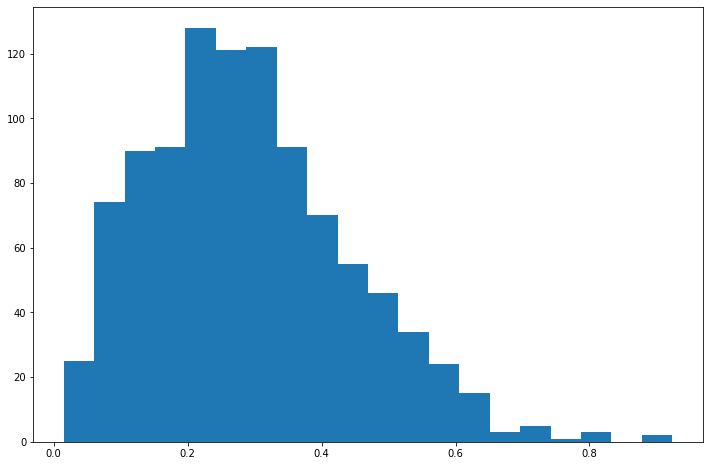

In [28]:
plt.hist(fit_es, bins=20)

(array([64., 43., 55., 50., 43., 47., 50., 50., 50., 46., 44., 51., 55.,
        69., 50., 50., 40., 51., 52., 40.]),
 array([-89.67545933, -80.69303463, -71.71060992, -62.72818521,
        -53.74576051, -44.7633358 , -35.78091109, -26.79848639,
        -17.81606168,  -8.83363698,   0.14878773,   9.13121244,
         18.11363714,  27.09606185,  36.07848655,  45.06091126,
         54.04333597,  63.02576067,  72.00818538,  80.99061008,
         89.97303479]),
 <a list of 20 Patch objects>)

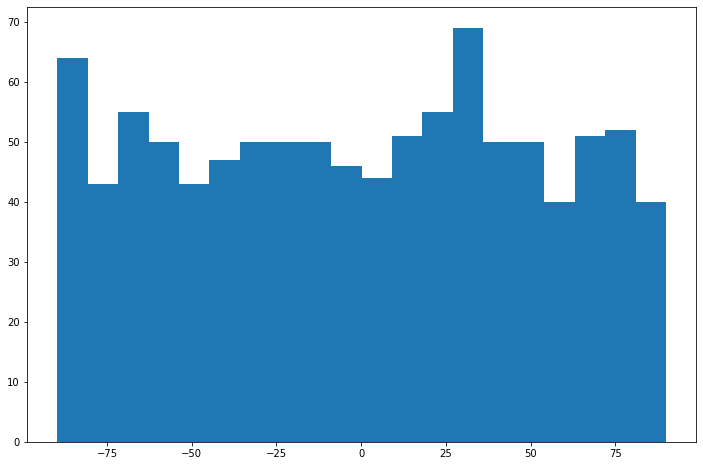

In [29]:
plt.hist(fit_ws, bins=20)